# MOVIE REVIEW SENTIMENT ANALYSIS WITH LSTM

# Classifying the sentiment of phrases from the Rotten Tomatoes datasets

Phrases are labelled on a scale of five values(0,1,2,3,4): negative, somewhat negative, neutral, somewhat positive and  positive respectively. Data comes with 3 features: PhraseId, SentenceId, and Phrase.

The model makes use of 1 feature(Phrase) out of the 3. The model is built with keras framework with tensorflow as backend. A recurrent neural network with LSTM cells are used for the model.

In [1]:
# importing necessary libraries
% matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras import layers
from keras.models import load_model 

E:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# loading data
def load_data(file):
    with open(file, 'r') as f:
        texts = f.read()
    return texts
data_dir = 'textsets/movie_sentiment_data' 
data_file = 'train.tsv'
file = os.path.join(data_dir, data_file)
data = load_data(file)

In [3]:
# data formatting
data = data.split('\n')
data = [x.split('\t') for x in data if len(x)>=1]

In [4]:
# showing first five lines
data[:5]

[['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'],
 ['1',
  '1',
  'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
  '1'],
 ['2',
  '1',
  'A series of escapades demonstrating the adage that what is good for the goose',
  '2'],
 ['3', '1', 'A series', '2'],
 ['4', '1', 'A', '2']]

In [5]:
# converting to dataframe
dframe = pd.DataFrame(data[1:], columns=data[0]) 

In [6]:
# showing first five lines
dframe.head() 

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
# selecting features and labels
text_data = dframe['Phrase']
targets = dframe['Sentiment']
print(text_data.head())
print(targets.head())

0    A series of escapades demonstrating the adage ...
1    A series of escapades demonstrating the adage ...
2                                             A series
3                                                    A
4                                               series
Name: Phrase, dtype: object
0    1
1    2
2    2
3    2
4    2
Name: Sentiment, dtype: object


In [8]:
# checking each label's frequency
targets.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [9]:
# checking size of features
len(text_data)

156060

In [10]:
# checking size of labels
len(targets)

156060

In [11]:
# cleaning texts
def clean_texts(text_data):
    texts = [x.lower() for x in text_data]
     # Removing numbers
    digits = '0123456789'
    texts = [''.join(c for c in x if c not in digits) for x in texts]
    # Removing punctuation
    texts = [''.join(c for c in x if c not in string.punctuation)
                 for x in texts]
    # Trimming extra whitespace
    texts = [' '.join(x.split()) for x in texts]
    return texts
texts = clean_texts(text_data) 

In [12]:
len(texts)

156060

In [13]:
texts[1]

'a series of escapades demonstrating the adage that what is good for the goose'

In [14]:
# splitting data into 75% train and 25% validation data
texts_train, texts_val, target_train, target_val = train_test_split(
    texts, targets, random_state=42)  

Data is divided into words of tokens with a vocabulary of 10,000 words and vectorized with digits for easy modelling.   

In [15]:
# splitting texts into tokens
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts_train)
# changing tokens into into sequence of numbers
train_data_seq = tokenizer.texts_to_sequences(texts_train)
val_data_seq = tokenizer.texts_to_sequences(texts_val)

In [16]:
# padding sequence of numbers with sequence lenght of 50
seq_len = 50
train_texts = sequence.pad_sequences(train_data_seq, maxlen=seq_len)
val_texts = sequence.pad_sequences(val_data_seq, maxlen=seq_len)

In [17]:
print('train data shape:', train_texts.shape)
print('validation data shape:', val_texts.shape)

train data shape: (117045, 50)
validation data shape: (39015, 50)


In [18]:
# one-hot encoding labels into size of class
num_classes = 5
train_target = to_categorical(target_train, num_classes=num_classes)
val_target = to_categorical(target_val, num_classes=num_classes)

Model architecture starts with an input layer of word embeddings. Followed by an LSTM layer with 32 nodes(arbitrary size). Next is a Dense layer of 32 nodes(arbitrary size) with a relu non-linear activation and finally an output dense layer of 5 nodes(according to the number of classes in the labels) with a softmax non-linear activation. In all there are 4 layers.

In [19]:
# defining model architecture
out_dim = 128
n_units = 32
vocab_size = 10000
model = Sequential()
model.add(Embedding(vocab_size, out_dim, input_length=seq_len))
model.add(LSTM(n_units))
model.add(Dense(n_units, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  

In [20]:
# displaying model achitecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 128)           1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 1,301,829
Trainable params: 1,301,829
Non-trainable params: 0
_________________________________________________________________


Model is compiled with a categorical crossentropy loss function (5 output probabilities), an RMSPROP algorithm with default learning rate of 0.001 for optimizing and evaluated with an accuracy metric.

In [21]:
# defining model evaluation parameters
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

Model is trained on mini batch size of 128 for each complete forward and back propagation for a total of 3 complete processes (epochs) and validated on the validation data

In [22]:
# model training for 3 epochs
history = model.fit(train_texts, train_target, 
                    batch_size=128, epochs=3,
                    validation_data=(val_texts, val_target))

Train on 117045 samples, validate on 39015 samples
Epoch 1/3
117045/117045 [==============================] - 2525s 22ms/step - loss: 1.0472 - acc: 0.5826 - val_loss: 0.9173 - val_acc: 0.6323
Epoch 2/3
117045/117045 [==============================] - 2349s 20ms/step - loss: 0.8684 - acc: 0.6523 - val_loss: 0.8760 - val_acc: 0.6472
Epoch 3/3
117045/117045 [==============================] - 2188s 19ms/step - loss: 0.8228 - acc: 0.6732 - val_loss: 0.8739 - val_acc: 0.6521


In [23]:
# saving first trained model
model.save('movie_review_01.h5')

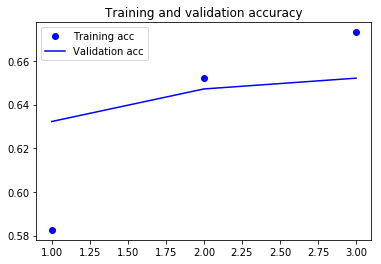

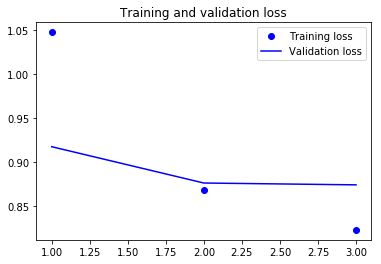

In [24]:
# plotting training and validation accuracy and losses
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Model architecture is modified by adding an extra LSTM layer with dropouts of 0.2 added to each hidden layer to handle overfitting of the model. 

In [25]:
# new model architecture with extra LSTM layer and dropouts
out_dim = 128
n_units = 32
vocab_size = 10000
model = Sequential()
model.add(Embedding(vocab_size, out_dim, input_length=seq_len))
model.add(LSTM(n_units, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(n_units))
model.add(layers.Dropout(0.2))
model.add(Dense(n_units, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))  

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 128)           1280000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 32)            20608     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', metrics= ['accuracy'])

In [28]:
# training model for 5 epochs
history = model.fit(train_texts, train_target,
                   batch_size=128, epochs=5,
                   validation_data=(val_texts, val_target))

Train on 117045 samples, validate on 39015 samples
Epoch 1/5
117045/117045 [==============================] - 4188s 36ms/step - loss: 1.1084 - acc: 0.5664 - val_loss: 0.9477 - val_acc: 0.6192
Epoch 2/5
117045/117045 [==============================] - 3708s 32ms/step - loss: 0.9051 - acc: 0.6421 - val_loss: 0.8875 - val_acc: 0.6440
Epoch 3/5
117045/117045 [==============================] - 3676s 31ms/step - loss: 0.8513 - acc: 0.6656 - val_loss: 0.8671 - val_acc: 0.6532
Epoch 4/5
117045/117045 [==============================] - 3683s 31ms/step - loss: 0.8202 - acc: 0.6794 - val_loss: 0.8527 - val_acc: 0.6601
Epoch 5/5
117045/117045 [==============================] - 3870s 33ms/step - loss: 0.7958 - acc: 0.6895 - val_loss: 0.8543 - val_acc: 0.6614


In [29]:
model.save('movie_review_02.h5')

In [30]:
# loading data for testing
test_file = 'test.tsv'
file = os.path.join(data_dir, test_file)
test_data = load_data(file)

In [31]:
len(test_data)

3367149

In [32]:
test_data[1]

'h'

In [33]:
# formatting test data
test_data = test_data.split('\n')
test_data = [x.split('\t') for x in test_data if len(x)>=1]

In [34]:
test_data[:5]

[['PhraseId', 'SentenceId', 'Phrase'],
 ['156061', '8545', 'An intermittently pleasing but mostly routine effort .'],
 ['156062', '8545', 'An intermittently pleasing but mostly routine effort'],
 ['156063', '8545', 'An'],
 ['156064', '8545', 'intermittently pleasing but mostly routine effort']]

In [35]:
test_data[-5:]

[['222348', '11855', 'A long-winded , predictable scenario .'],
 ['222349', '11855', 'A long-winded , predictable scenario'],
 ['222350', '11855', 'A long-winded ,'],
 ['222351', '11855', 'A long-winded'],
 ['222352', '11855', 'predictable scenario']]

In [36]:
len(test_data)

66293

In [37]:
tframe = pd.DataFrame(test_data[1:], columns=test_data[0])

In [38]:
tframe.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [39]:
test_phrases = tframe['Phrase']

In [40]:
print(test_phrases.head())
print(test_phrases.tail())

0    An intermittently pleasing but mostly routine ...
1    An intermittently pleasing but mostly routine ...
2                                                   An
3    intermittently pleasing but mostly routine effort
4           intermittently pleasing but mostly routine
Name: Phrase, dtype: object
66287    A long-winded , predictable scenario .
66288      A long-winded , predictable scenario
66289                           A long-winded ,
66290                             A long-winded
66291                      predictable scenario
Name: Phrase, dtype: object


In [41]:
test_phrase = clean_texts(test_phrases)

In [42]:
print(len(test_phrase))
print(test_phrase[1])

66292
an intermittently pleasing but mostly routine effort


In [43]:
test_data_seq = tokenizer.texts_to_sequences(test_phrase)

In [44]:
test_pad = sequence.pad_sequences(test_data_seq, maxlen=seq_len)

In [46]:
model = load_model('movie_review_02.h5')

In [47]:
# predicting test phrases
predicted = model.predict_classes(test_pad, verbose=0)

In [50]:
# showing predicted sentiments
for i in range(5):
    print('Phrase:{} | Sentiment:{}'.format(
        test_phrases[i], predicted[i]))

Phrase:An intermittently pleasing but mostly routine effort . | Sentiment:2
Phrase:An intermittently pleasing but mostly routine effort | Sentiment:2
Phrase:An | Sentiment:2
Phrase:intermittently pleasing but mostly routine effort | Sentiment:2
Phrase:intermittently pleasing but mostly routine | Sentiment:2
